In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Resize notebook screen

In [6]:
df = pd.read_excel('test-data.xlsx')
df.dropna(how='all', inplace=True) # Drop empty lines
df['Duration'] = df['Duration'].fillna(1).astype(np.int32) # Replace missing duration with 1 (one hour) an change column type to integer
df['Category'] = df['Category'].fillna('Other') # Replace missing category name with Other
df['Start'] = df['Start'].fillna(min(df['Start'])) # Replace missing start time with min date
df['End'] = df['Start'] + df['Duration'] * pd.Timedelta(days=1) # Helper column with task end date

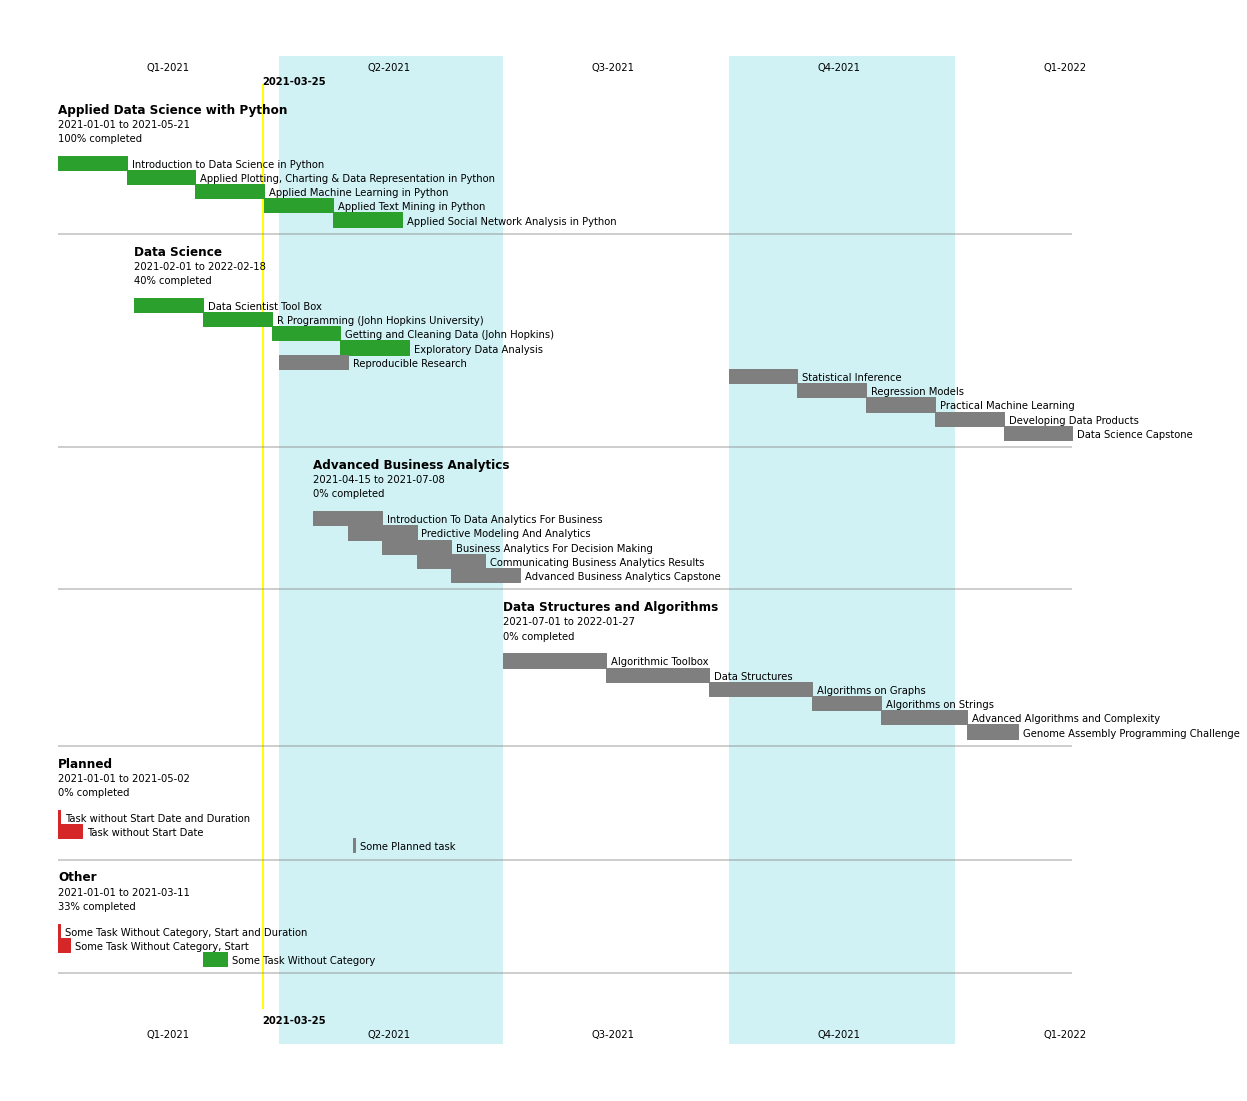

In [11]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')

# Today line
today = pd.Timestamp.today()
today_line_length = len(df) + len(df['Category'].unique()) * 4 + 6 # Number of tasks + 4 * number of groups + margins
ax.vlines(today, ymin=-3, ymax=today_line_length, color='yellow', lw=2, zorder=-1) # Draw vertical line on today's mark
ax.text(today, -3, today.date(), fontweight='bold')
ax.text(today, today_line_length + 1, today.date(), fontweight='bold')

# Quarters bars 
q = pd.date_range(min(df['Start']), freq='QS', periods=(max(df['End']) - min(df['Start'])).days//91+1)
for i, quarter in enumerate(q):
    if (i % 2 == 1) and (i<len(q)-1): ax.fill_between((q[i],q[i+1]), -5, today_line_length+2.5, facecolor='tab:cyan', alpha = 0.2)
    quarter_label = 'Q'+str(quarter.quarter)+'-'+str(quarter.year)
    ax.text(quarter + pd.DateOffset(days=45), -4, quarter_label, ha='center') # Display today's date on top
    ax.text(quarter + pd.DateOffset(days=45), today_line_length+2, quarter_label, ha='center') # Dsiplay today's date in bottom

ax.invert_yaxis() # y axis starts at top and ends in bottom
group_start_y = -1 # Where to start plotting first group 

# Main loop, for each group draw the group summary and all the tasks
for group in df.groupby('Category', sort=False): # Don't sort, by default i would be sorted alphabetically
    group_name = group[0] # Group name
    df_g = group[1] # Group dataframe
    group_size_y = len(df_g) + 1 # Count of group members + 1 row margin
    group_start_x = min(df_g['Start']).date() # Soonest date in the group
    group_end_x = max(df_g['End']).date() # Latest date in group (max start date + duration)
    
    
    # Display group name and summary  
    ax.text(group_start_x, group_start_y, group_name, size='large', fontweight='bold') # Group name
    group_duration_str = str(group_start_x) + ' to ' + str(group_end_x) # Group start and end date
    ax.text(group_start_x, group_start_y+1, group_duration_str) # Group duration
    ax.text(group_start_x, group_start_y+2, str(int(len(df_g[~df_g['Completed'].isnull()])/len(df_g) *100)) + '% completed') # Completion percentage
    group_start_y += 3 # Where to start with tasks
    ax.hlines(group_start_y + group_size_y - 0.5, xmin=min(df['Start']), xmax=max(df['End']), color='tab:grey', alpha=0.5)
    
    # Display each task
    for i, task_name in enumerate(df_g['Name']):
        task = df_g.iloc[i]
        
        # Get bar color
        task_color = 'tab:grey' # Planned
        if task['End'] < today: task_color = 'tab:red' # Overdue
        if task['Completed'] < today: task_color = 'tab:green'  # Completed     

        ax.broken_barh([(task['Start'],task['Duration'])],(group_start_y+i,1), color=task_color) # Draw bar
        ax.text(task['Start']+task['Duration'] * pd.DateOffset(days=1) + pd.DateOffset(days=2),group_start_y+i+0.6,task_name, va='center') # bar label - task name
        
    group_start_y += group_size_y + 1 # One row space between group end and start of another group 
plt.savefig('gantt.png', format='png') # Save chart to PNG